# Hazard assessment for river flooding using river discharge statistics
## Analyzing historical river discharge statistics

This workflow uses the dataset of hydrological climate impact indicators by SMHI that is [available via the Copernicus Data Store](https://doi.org/10.24381/cds.73237ad6).

To execute this notebook, the dataset of European river discharges will first be retrieved from the CLIMAAX data server, where a prepared copy is stored for easier and faster access. However, if you would like to download the data directly from CDS or if the dataset copy is not available, you can use the previous notebook `01_river_discharges_get_data.ipynb` to download the data.

### Select area of interest
First, we will define the coordinates of the area of interest. Based on these coordinates we will be able to identify the relevant catchment within the river discharges dataset and subset the data for further processing.

The river discharges dataset contants river discharges corresponding to a large number of small-scale catchments. Below we can specify coordinates of a location (WGS84 coordinates) that corresponds to the section of a river that we are interested in. This location will subsequently be snapped to the corresponding catchment in the dataset.

The `areaname` variable will be used when adding titles to figures or saving output files.

In [ ]:
areaname = 'Putna_Romania'
loc = [26.84194444, 45.88861111]

# areaname = 'Zilina_Slovakia'
# loc = [18.717, 49.25]

# areaname = 'Maastricht_NL'
# loc = [5.697, 50.849]

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- cdsapi
- zipfile
- cartopy
- geopandas

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [ ]:
import os
from glob import glob
import numpy as np
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import contextily as ctx
from shapely.geometry import Point

### Create the directory structure
Firt we need to create the directory structure where the inputs and outputs of the workflow are stored.  
In the next cell will create the directory called 'FLOOD_RIVER_discharges' in the same directory where this notebook is saved.

If you have already ran the notebook for downloading the river discharges dataset directly from CDS (`01_river_discharges_get_data.ipynb`), the workflow folder may already be present on your computer, and the pre-processed data is already found in the path defined under `data_folder`. Otherwise, the preprocessed data will be retrieved in this notebook from the CLIMAAX data server.

In [ ]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_RIVER_discharges'
os.makedirs(workflow_folder, exist_ok=True)

#data_folder = os.path.join(workflow_folder, 'data')
data_folder = r'n:\My Documents\projects\CLIMAAX\River_discharges\FLOOD_RIVER_discharges\data'
os.makedirs(data_folder, exist_ok=True)

In [ ]:
# Define directory for plots within the previously defined workflow folder
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')
os.makedirs(plot_dir, exist_ok=True)

### Checking data availability
In this step we will check if the necessary data is already available in the workflow folder and download the missing files.

In [ ]:
if os.path.exists(os.path.join(data_folder, 'rdis_day_E-HYPEcatch_allmodels.nc')):
    print('Dataset of daily river discharges is already downloaded.')
else:
    print('Downloading the dataset of daily river discharges ...')
    #TODO: code to download the data 

if os.path.exists(os.path.join(data_folder, 'rdis_ymonmean_abs_E-HYPEcatch_allmodels.nc')):
    print('Dataset of monthly mean river discharges is already downloaded.')
else:
    print('Downloading the dataset of monthly mean river discharges ...')
    #TODO: code to download the data 

if os.path.exists(os.path.join(data_folder, 'rdisreturnmax50_abs_E-HYPEcatch_allmodels.nc')):
    print('Dataset of extreme river discharges with 50-year return period (absolute values) is already downloaded.')
else:
    print('Downloading the dataset of extreme river discharges with 50-year return period ...')
    #TODO: code to download the data 

if os.path.exists(os.path.join(data_folder, 'rdisreturnmax50_rel_E-HYPEcatch_allmodels.nc')):
    print('Dataset of extreme river discharges with 50-year return period (relative change) is already downloaded.')
else:
    print('Downloading the dataset of relative changes in extreme river discharges with 50-year return period ...')
    #TODO: code to download the data 

We will open the files containing the dataset under variables `ds_day` for daily river discharge timeseries and `ds_mon` for monthly mean river discharges:

In [ ]:
ds_day = xr.open_dataset(os.path.join(data_folder, 'rdis_day_E-HYPEcatch_allmodels.nc'))
ds_day

In [ ]:
ds_mon = xr.open_dataset(os.path.join(data_folder, 'rdis_ymonmean_abs_E-HYPEcatch_allmodels.nc'))
ds_mon

In [ ]:
ds_flood = xr.open_dataset(os.path.join(data_folder, 'rdisreturnmax50_abs_E-HYPEcatch_allmodels.nc'))
ds_flood

In [ ]:
ds_flood_rel = xr.open_dataset(os.path.join(data_folder, 'rdisreturnmax50_rel_E-HYPEcatch_allmodels.nc'))
ds_flood_rel

### Selecting the catchment of interest
The river discharges dataset contains discharges corresponding to a large number of small-scale catchments, identified using a catchment ID (coordinate `id` in the dataset). For further analysis, we need to be able to subset the dataset to a specific catchment in our area of interest. In order to know the ID of the catchment we are interested in, we need to consult the map of catchments (sub-basins) [available in shp format on Zenodo](https://doi.org/10.5281/zenodo.581451). Please download the dataset of subbasins from Zenodo and unzip it in the folder specied as `data_folder_subbasins` located in the `data_folder` (this folder is created below).

Reference to the dataset of subbasin contours:  
Isberg, K. (2017). EHYPE3_subbasins.zip [Data set]. Zenodo. https://doi.org/10.5281/zenodo.581451

In [ ]:
data_folder_subbasins = os.path.join(data_folder, 'EHYPE3_subbasins')

We can open the dataset of catchment contours as a GeoDataFrame variable:

In [ ]:
# Open dataset with subbasin contours
try:
    catchments = gpd.GeoDataFrame.from_file(os.path.join(data_folder_subbasins, 'EHYPE3_subbasins.shp'))
    print("Dataset loaded.")
except:
    print(f"Dataset with subbasin contours not found. Please download it and place it in the folder {data_folder_subbasins}")

catchments

Now we need to identify the id of the catchment where the point of interest is located based on the coordinates stored in the variable `loc`:

In [12]:
point = Point((loc[0],loc[1]))

in_catchment = catchments.geometry.contains(point)

catch_id = int(catchments.iloc[in_catchment.index[in_catchment==True]].SUBID.values.tolist()[0])
print(f'Catchment ID in the E-HYPEcatch dataset: {catch_id}')

Catchment ID in the E-HYPEcatch dataset: 9601909


The catchment ID and contours will be stored in the variable `catchment`.

In [13]:
catchment = catchments[catchments.SUBID==catch_id]
catchment

,SUBID,HAROID,geometry
29282,9601909.0,9600704.0,"POLYGON ((26.77084 46.00417, 26.77084 45.99583..."


Below the catchment contours will be plotted on a map to check whether correct catchment is selected.

Text(0.5, 1.0, 'Catchment contours from E-HYPEcatch corresponding to the location of interest')

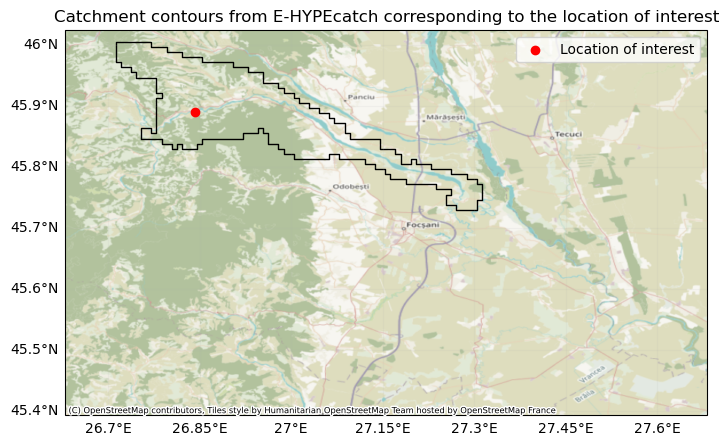

In [ ]:
# Plot the catchment on a ctx map
fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot2grid((1, 1), (0, 0), colspan=2, projection=ccrs.PlateCarree())

# plot data on the map
ax0.set_ylim([loc[1]-0.5, loc[1]+0.5])
ax0.set_xlim([loc[0]-0.5, loc[0]+0.5])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

catchment.geometry.plot(ax=ax0, facecolor='None')

ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)

ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')

### Checking daily timeseries of historical river discharges

TODO: 
- plot daily timeseries
- check differences between catchment model realizations and potentially take median between these realizations
- check differences between climate models (different seed, not possible to aggregate on daily basis)
- derive flow duration curves for each GCM-RCM combination
- visualize the FDC
- suggest comparing to local data

TODO

TODO


### Checking the seasonal variations in the historical river discharges

Select only the data for the specific catchment:

In [ ]:
ds_mon_sel = ds_mon.sel(id=catch_id)

Check variation in results due to different catchment models in the E-HYPEcatch multi-model ensemble for historical period:

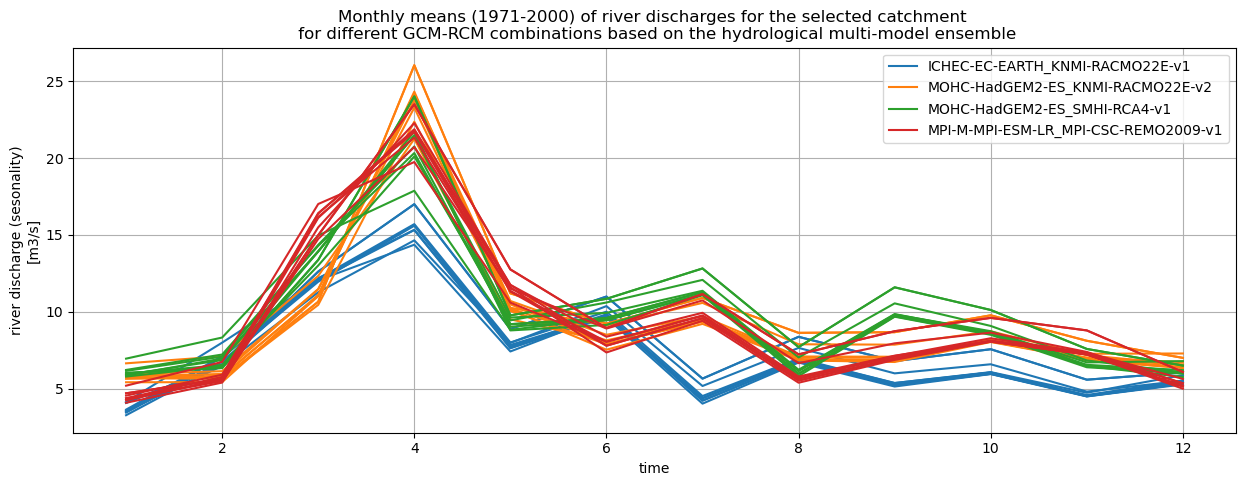

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

colors = mcolors.TABLEAU_COLORS
colorlist = list(colors.keys())

for ii, model in enumerate(ds_cat_sel['gcm_rcm'].values):
    ds_mon_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').isel(gcm_rcm=ii, catchmodel=0).plot.line(ax=ax, x='time', color=colorlist[ii], label=model, alpha=0.7)
    ds_mon_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').isel(gcm_rcm=ii).plot.line(ax=ax, x='time', color=colorlist[ii], alpha=0.7) 

ax.grid()
ax.legend()
ax.set_title('Monthly means (1971-2000) of river discharges for the selected catchment \n for different GCM-RCM combinations based on the hydrological multi-model ensemble');

**Reflect on the plot above:** is there a lot of variation in river discharges across the E-HYPEcatch model ensemble when looking at one specific GCM-RCM model combination? In the example above the variation is limited.
We can now plot river discharges averaged across the hydrological multi-model ensemble:

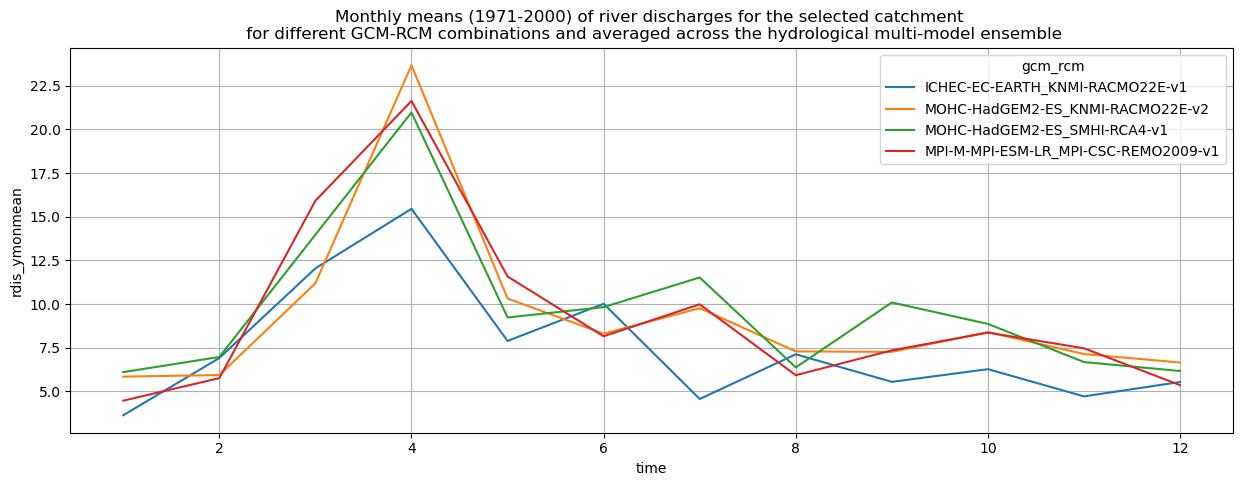

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ds_mon_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').mean(dim='catchmodel').plot.line(ax=ax, x='time')
ax.grid() 
ax.set_title('Monthly means (1971-2000) of river discharges for the selected catchment \n for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble');

**Reflect on the plot above:** do the river discharges for this catchment correspond to the local experience of this specific area both in seasonal pattern and magnitude? If there are significant differences then it may be concluded that the model is less suitable for the river flood hazard assessment in this specific area, e.g. due to low resolution or due to some relevant processes not being included (i.e. water management infrastructure such as dams).

### Selecting representative GCM-RCM model combinations (optional)


TODO: implement option to exclude certain GCM-RCM combinations from the analysis!


TODO

TODO

### Monthly river discharges under climate change scenarios

The monthly means are aggregated as a mean between catchment model realizations, as well as mean of the selected GCM-RCM combinations to produce the plot below:

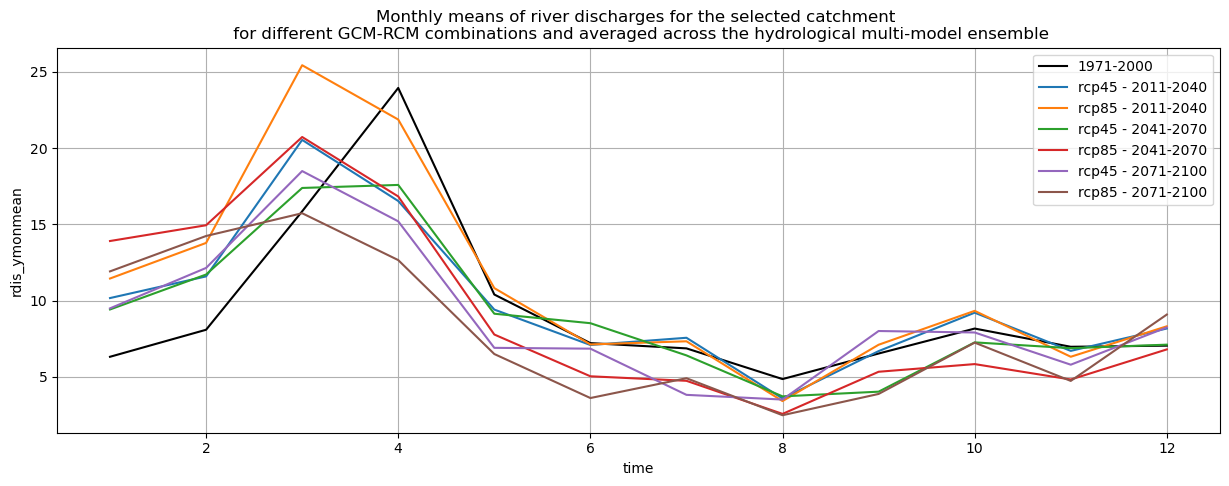

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ds_mon_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').mean(dim='catchmodel').mean(dim='gcm_rcm').plot.line(ax=ax, x='time', label='1971-2000', color='k')

for timep in ['2011-2040', '2041-2070', '2071-2100']:
    for scen in ['rcp45', 'rcp85']:
        ds_mon_sel['rdis_ymonmean'].mean(dim='catchmodel').mean(dim='gcm_rcm').sel(scenarios=scen, time_period=timep).plot.line(ax=ax, x='time', label=f'{scen} - {timep}')
ax.grid() 
ax.legend()
ax.set_title('Monthly means of river discharges for the selected catchment \n for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble');

TODO: add reflection on the plot above

### Flood occurence in historical and future climates

In [ ]:
# Subset to catchment of interest
ds_flood_sel = ds_flood.sel(id=catch_id)
ds_flood_sel

Visualize flood occurence data - influence of timeline and scenario

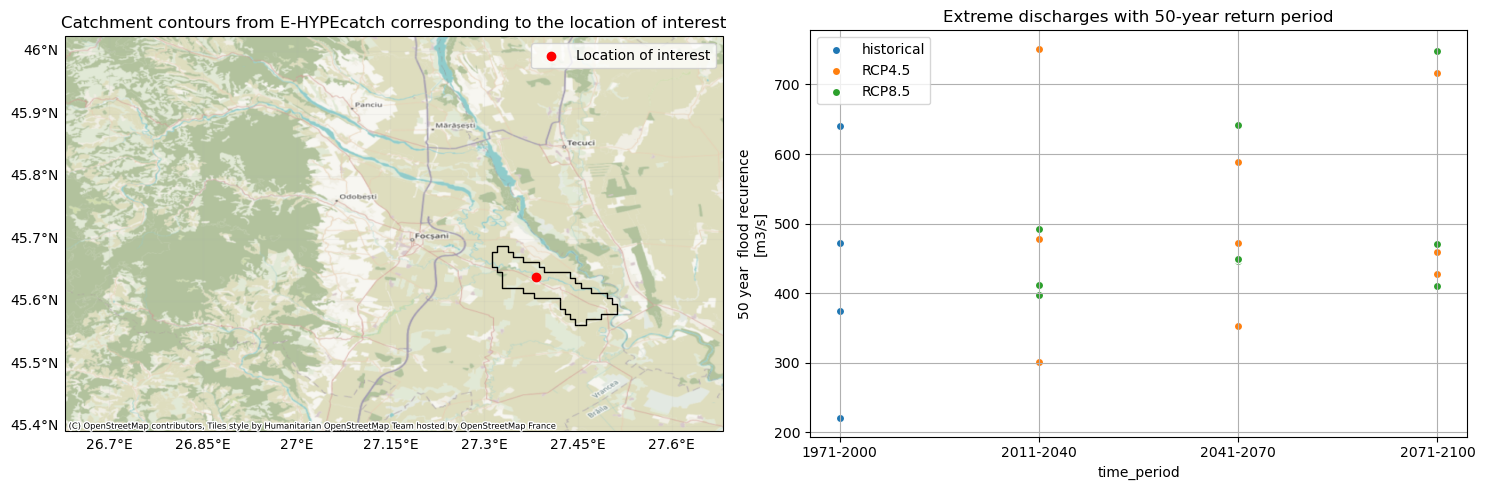

In [91]:
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 4), (0, 2), colspan=2)

# plot catchment contours on map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False
catchment.geometry.plot(ax=ax0, facecolor='None')
ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()
ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)
ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')

# Plot flood occurence data
ds_flood_sel['rdisreturnmax50_tmean'].sel(scenarios='historical').plot.scatter(ax=ax1, x='time_period', label='historical')
ds_flood_sel['rdisreturnmax50_tmean'].sel(scenarios='rcp45').plot.scatter(ax=ax1, x='time_period', label='RCP4.5')
ds_flood_sel['rdisreturnmax50_tmean'].sel(scenarios='rcp85').plot.scatter(ax=ax1, x='time_period', label='RCP8.5')
ax1.grid()
ax1.legend()
ax1.set_title('Extreme discharges with 50-year return period')
plt.tight_layout()

The above comparison can also be plotted in terms of relative change in extreme discharges:

In [ ]:
# Subset to catchment of interest
ds_flood_rel_sel = ds_flood_rel.sel(id=catch_id)

In [94]:
ds_flood_rel_sel

<xarray.Dataset> Size: 764B
Dimensions:                (scenarios: 2, gcm_rcm: 4, time: 3)
Coordinates:
    id                     int32 4B 9602650
  * time                   (time) datetime64[ns] 24B 2011-01-01 ... 2071-01-01
  * gcm_rcm                (gcm_rcm) <U36 576B 'MOHC-HadGEM2-ES_KNMI-RACMO22E...
  * scenarios              (scenarios) <U5 40B 'rcp45' 'rcp85'
    time_period            (time) object 24B '2011-2040' '2041-2070' '2071-2100'
Data variables:
    rdisreturnmax50_tmean  (scenarios, gcm_rcm, time) float32 96B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/30)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    comment:                  -
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    ...                       ...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    reference_period:         1971-2000
    variable_name:            rdisreturnmax50_tmean
    contact:                  copernicus-support@ecmwf.int

c:\Users\aleksand\AppData\Local\miniforge3\envs\climaax_floods\Lib\site-packages\matplotlib\colors.py:1318: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
c:\Users\aleksand\AppData\Local\miniforge3\envs\climaax_floods\Lib\site-packages\matplotlib\colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


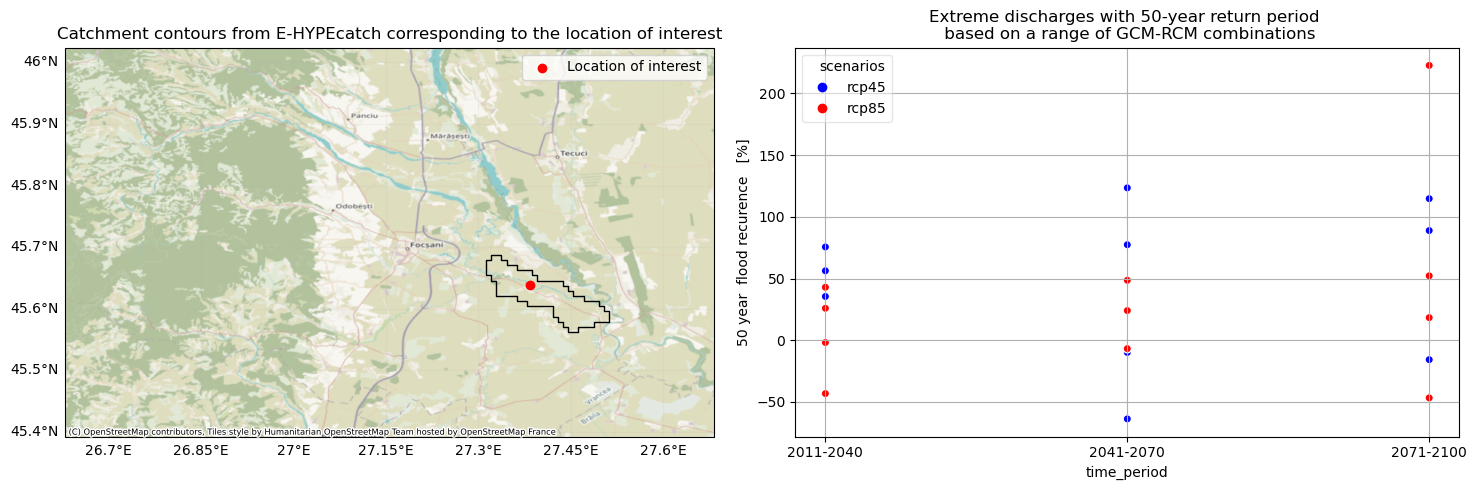

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 4), (0, 2), colspan=2)

# plot catchment contours on map
ax0.set_ylim([loc[1]-0.5, loc[1]+0.5])
ax0.set_xlim([loc[0]-0.5, loc[0]+0.5])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False
catchment.geometry.plot(ax=ax0, facecolor='None')
ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()
ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)
ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')

# Plot flood occurence data
ds_flood_rel_sel['rdisreturnmax50_tmean'].plot.scatter(x='time_period', hue='scenarios', add_legend=True, add_colorbar=False, cmap='bwr')
ax1.grid()
ax1.set_title('Extreme discharges with 50-year return period \n based on a range of GCM-RCM combinations')
plt.tight_layout()

There can be a significant spread in estimated increase in extreme discharges across GCM-RCM combinations (climate models). We can check the average estimates and their range based on the data above:

In [96]:
for scen in ['rcp45', 'rcp85']:
       for time_period in ['2011-2040', '2041-2070', '2071-2100']:
              msg = f'Scenario {scen.upper()}, time period {time_period}: increase in 50-year extreme discharge is ' + \
                     f'{ds_flood_rel_sel['rdisreturnmax50_tmean'].sel(scenarios=scen).where(ds_flood_rel_sel['time_period']==time_period, drop=True).mean(dim='gcm_rcm').values[0]:.1f}%' + \
                     f' ({ds_flood_rel_sel['rdisreturnmax50_tmean'].sel(scenarios=scen).where(ds_flood_rel_sel['time_period']==time_period, drop=True).min(dim='gcm_rcm').values[0]:.1f}% to ' + \
                     f'{ds_flood_rel_sel['rdisreturnmax50_tmean'].sel(scenarios=scen).where(ds_flood_rel_sel['time_period']==time_period, drop=True).max(dim='gcm_rcm').values[0]:.1f}%)'
              print(msg)
              print()

Scenario RCP45, time period 2011-2040: increase in 50-year extreme discharge is 55.8% (35.5% to 75.6%)

Scenario RCP45, time period 2041-2070: increase in 50-year extreme discharge is 31.8% (-63.7% to 123.5%)

Scenario RCP45, time period 2071-2100: increase in 50-year extreme discharge is 62.6% (-15.7% to 114.7%)

Scenario RCP85, time period 2011-2040: increase in 50-year extreme discharge is 6.0% (-43.2% to 43.0%)

Scenario RCP85, time period 2041-2070: increase in 50-year extreme discharge is 22.0% (-6.8% to 48.6%)

Scenario RCP85, time period 2071-2100: increase in 50-year extreme discharge is 61.7% (-46.7% to 222.7%)



Author of the workflow:  
Natalia Aleksandrova (Deltares)